In [244]:
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import Keys, ActionChains
import numpy as np

service = Service()

# if you want to get fancy with the options
# here the the ChromeOptions documentation: https://chromedriver.chromium.org/capabilities#h.p_ID_102
# here is the list of Chrome arguments: https://peter.sh/experiments/chromium-command-line-switches/
# there are a lot...
chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("detach", True) # this keeps the window open post execution/errors/ changing frames (explained later)

prefs = {"download.default_directory": '/Users/justinpaul/Downloads',  # note need to change this
         "directory_upgrade": True}
chrome_options.add_experimental_option("prefs", prefs)


In [245]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests


In [246]:
# driver = webdriver.Chrome('/usr/local/bin/chromedriver')
# driver = webdriver.Chrome('/usr/local/bin/chromedriver', options=chrome_options)
driver = webdriver.Chrome(service=service, options=chrome_options)
url = 'https://play2048.co/'
print(url)
driver.set_page_load_timeout(30) 
try: 
    driver.get(url)
    # driver.navigate.to("https://play2048.co/");
except: 
    print('error') 


# if this didn't work, may need to follow tutorial:
# for Windows: https://cloudbytes.dev/snippets/run-selenium-and-chrome-on-wsl2#step-2-install-latest-chrome-for-linux
# for Mac: https://github.com/MichiganDataScienceTeam/W23-Webscraping/blob/main/meetings/meeting_selenium.MD

https://play2048.co/


In [247]:

soup = BeautifulSoup(driver.page_source, "html.parser")


In [248]:
actions = ActionChains(driver)

In [249]:
def get_board():
    soup = BeautifulSoup(driver.page_source, "html.parser")
    tile_div = soup.find('div', class_='tile-container')
    tiles = tile_div.find_all("div", class_='tile')
    board = np.zeros((4,4))
    for tile in tiles:
        position = tile.get('class')[2].split('-')[2:4]
        board[int(position[1]) - 1, int(position[0]) - 1] = tile.div.text
    return board

In [250]:
# STRATEGY 1: UP-LEFT-DOWN-RIGHT REPEAT 
def circular(num_iterations):
    scores = []
    max_tiles = []
    for i in range(num_iterations):
        while len(driver.find_elements(By.CLASS_NAME, "game-over")) == 0:
            actions.send_keys(Keys.ARROW_UP)
            actions.send_keys(Keys.ARROW_LEFT)
            actions.send_keys(Keys.ARROW_DOWN)
            actions.send_keys(Keys.ARROW_RIGHT)
            actions.perform()
        scores.append(int(driver.find_element(By.CLASS_NAME, "score-container").text.split()[0]))
        max_tiles.append(np.max(get_board()))
        driver.find_element(By.CLASS_NAME, "retry-button").click()
    return scores, max_tiles

In [251]:
# STRATEGY 2: RANDOM 
def random_strat(num_iterations):
    key_map = {0: Keys.ARROW_UP, 1: Keys.ARROW_LEFT, 2: Keys.ARROW_DOWN, 3: Keys.ARROW_RIGHT}
    scores = []
    max_tiles = []
    for i in range(num_iterations):
        while len(driver.find_elements(By.CLASS_NAME, "game-over")) == 0:
            for j in range(4):
                actions.send_keys(key_map[np.random.randint(0,4)])
            actions.perform()
        scores.append(int(driver.find_element(By.CLASS_NAME, "score-container").text.split()[0]))
        max_tiles.append(np.max(get_board()))
        driver.find_element(By.CLASS_NAME, "retry-button").click()
    return scores, max_tiles

In [252]:
# [0 = up][1 = left][2 = down][3 = right]
# GETS BEST PAIR CURRENTLY ON THE BOARD
def greedy_pair(board):
  action = -1
  value = -1
  tempAction = -1
  tempValue = -1

  # Iterates over array
  for i in range(4):
    for j in range(4):
      # If there is a 2 or 4 and an empty space, move there
      if (board[i][j] == 2):
        if j != 3 and (board[i][j + 1] == 0):
          tempValue = 2
          tempAction = 3
        if j != 0 and (board[i][j - 1] == 0):
          tempValue = 2
          tempAction = 1
        if i != 3 and board[i + 1][j] == 0:
          tempValue = 2
          tempAction = 2
        if i != 0 and board[i - 1][j] == 0:
          tempValue = 2
          tempAction = 0
      if (board[i][j] == 4):
        if j != 3 and (board[i][j + 1] == 0):
          tempValue = 4
          tempAction = 3
        if j != 0 and (board[i][j - 1] == 0):
          tempValue = 4
          tempAction = 1
        if i != 3 and board[i + 1][j] == 0:
          tempValue = 4
          tempAction = 2
        if i != 0 and board[i - 1][j] == 0:
          tempValue = 4
          tempAction = 0

      # Compares elements in the same row
      if j != 3 and board[i][j] == board[i][j + 1]:
        tempValue = board[i][j] * 2
        tempAction = 3
      elif j != 0 and board[i][j] == board[i][j - 1]:
        tempValue = board[i][j] * 2
        tempAction = 1

      # Compares elements in the same column
      if i != 3 and board[i][j] == board[i + 1][j]:
        tempValue = board[i][j] * 2
        tempAction = 2
      elif i != 0 and board[i][j] == board[i - 1][j]:
        tempValue = board[i][j] * 2
        tempAction = 0

      # Maximum value
      if tempValue > value:
        value = tempValue
        action = tempAction

  return action


In [253]:
# STRATEGY 3 AGAIN: CORNER METHOD
def corner(num_iterations):
    # Corner method
    scores = []
    max_tiles = []
    for i in range(num_iterations):
        action = ActionChains(driver)
        
        while len(driver.find_elements(By.CLASS_NAME, "game-over")) == 0:
        
            state_0 = soup.find('div', class_="tile-position-4-1")
            
            action.send_keys(Keys.ARROW_UP)
            action.send_keys(Keys.ARROW_LEFT)
            action.perform()
            
            state_1 = soup.find('div', class_="tile-position-4-1")
            
            if (state_0 == state_1):
                for i in range(3):
                    board = get_board()
                    value = greedy_pair(board)
                    if value == 0:
                      action.send_keys(Keys.ARROW_UP)
                    if value == 1:
                      action.send_keys(Keys.ARROW_LEFT)
                    if value == 2:
                      action.send_keys(Keys.ARROW_DOWN)
                    if value == 3:
                      action.send_keys(Keys.ARROW_RIGHT)
                    action.perform()
        
        scores.append(int((driver.find_element(By.CLASS_NAME, "score-container").text.split()[0])))
        max_tiles.append(np.max(get_board()))
        driver.find_element(By.CLASS_NAME, "retry-button").click()
    return scores, max_tiles

In [254]:
# STRATEGY 4: PUSHING BIG SCORES DOWN BUT NOT INTO ONE CORNER
def down(num_iterations):
    key_map = {0: Keys.ARROW_UP, 1: Keys.ARROW_LEFT, 2: Keys.ARROW_DOWN, 3: Keys.ARROW_RIGHT}
    scores = []
    max_tiles = []
    for i in range(num_iterations):
        while len(driver.find_elements(By.CLASS_NAME, "game-over")) == 0:
            board1 = get_board()
            actions.send_keys(key_map[2])
            actions.send_keys(key_map[2])
            actions.send_keys(key_map[2])
            actions.send_keys(key_map[2])
            actions.send_keys(key_map[3])
            actions.send_keys(key_map[2])
            actions.send_keys(key_map[1])
            actions.perform()
            board2 = get_board()
            
            if (np.array_equal(board1, board2)):
                for i in range(3):
                    move = greedy_pair(board2)
                    if move != -1:
                        actions.send_keys(key_map[move])
                    if move == 0:
                      actions.send_keys(key_map[2])
                    elif move == 3:
                      actions.send_keys(key_map[1])
                    actions.perform()
                    
        scores.append(int(driver.find_element(By.CLASS_NAME, "score-container").text.split()[0]))
        max_tiles.append(np.max(get_board()))
        driver.find_element(By.CLASS_NAME, "retry-button").click()
    return scores, max_tiles

In [302]:
# Gets # of points given an up or down move
def vertical_points(board):
    points = 0
    for col in range(4):
        start = 3
        end = 2
        while end >= 0:
            if board[start, col] == 0:
                start -= 1
                if start == end:
                    end -= 1
            elif board[start, col] != 0 and board[end, col] == 0:
                end -= 1
            elif board[start, col] != 0 and board[end, col] != 0 and board[start, col] != board[end, col]:
                start = end
                end -= 1
            else:
                points += (board[start, col] * 2)
                start = end - 1
                end -= 2

    return points

In [316]:
# points if you move left or right
def horizontal_points(board):
    points = 0
    for row in range(4):
        start = 3
        end = 2
        while end >= 0:
            if board[row, start] == 0:
                start -= 1
                if start == end:
                    end -= 1
            elif board[row, start] != 0 and board[row, end] == 0:
                end -= 1
            elif board[row, start] != 0 and board[row, end] != 0 and board[row, start] != board[row, end]:
                start = end
                end -= 1
            else:
                points += (board[row, start] * 2)
                start = end - 1
                end -= 2
    return points

In [1]:
# greedy: chooses direction with most points gained (favoring left and down)
def greedy_method(num_iterations):
    key_map = {0: Keys.ARROW_UP, 1: Keys.ARROW_LEFT, 2: Keys.ARROW_DOWN, 3: Keys.ARROW_RIGHT}
    actions = ActionChains(driver)
    scores = []
    max_tiles = []
    for i in range(num_iterations):
        while len(driver.find_elements(By.CLASS_NAME, "game-over")) == 0:
            board = get_board()
            left = horizontal_points(board)
            down = vertical_points(board)
            if left > down:
                actions.send_keys(key_map[1])  
            else:
                actions.send_keys(key_map[2])
            actions.perform()
            board2 = get_board()
            if np.array_equal(board, board2):
                actions.send_keys(key_map[3])
                actions.send_keys(key_map[1])
                actions.perform()
                board3 = get_board()
                if np.array_equal(board2, board3):
                    actions.send_keys(key_map[0])
                    actions.send_keys(key_map[2])
                    actions.perform()
        scores.append(int((driver.find_element(By.CLASS_NAME, "score-container").text.split()[0])))
        max_tiles.append(np.max(get_board()))
        driver.find_element(By.CLASS_NAME, "retry-button").click()
    return scores, max_tiles

In [218]:
from matplotlib import pyplot as plt 
from collections import Counter

In [219]:
# TESTING

In [3]:
def barplot(tiles):
    freq_dict = {}
    for number in tiles:
        if number in freq_dict:
            freq_dict[number] += 1
        else:
            freq_dict[number] = 1

    key_order = sorted(list(freq_dict.keys()))
    sorted_dict = {i: freq_dict[i] for i in key_order}
    print(sorted_dict.keys())
    x_axis = list(map(str, sorted_dict.keys()))
    y_axis = list(sorted_dict.values())
    # Create a bar plot
    plt.bar(x_axis, y_axis)


    # Add labels and title
    plt.xlabel('Largest Tile Values')
    plt.ylabel('Frequency')
    plt.title("Greedy Method Largest Tiles Bar Chart")

    # Show the plot
    plt.show()


In [ ]:
circular_scores = circular(100)
print("circular scores: ", circular_scores[0])
print("circular max tiles: ", circular_scores[1])

hist = np.histogram(circular_scores[0])
_ = plt.hist(circular_scores[0], bins='auto')  # arguments are passed to np.histogram
plt.title("Circular Method Scores Histogram")
plt.show()

In [4]:
barplot(circular_scores[1])

NameError: name 'circular_scores' is not defined

In [ ]:
random_strat_scores = random_strat(100)
print("random: ", random_strat_scores[0]) # result: 
print("random max tiles: ", random_strat_scores[1])

hist = np.histogram(random_strat_scores[0])
_ = plt.hist(random_strat_scores[0], bins='auto')  # arguments are passed to np.histogram
plt.title("Random Method Scores Histogram")
plt.show()

In [ ]:
barplot(random_strat_scores[1])

In [273]:
corner_scores = corner(100)
print("corner scores: ", corner_scores[0])
print("corner max tiles: ", corner_scores[1])

corner scores:  [624, 1292, 1516, 2868, 1024, 1656, 1300, 708, 2352, 1572, 1368, 1380, 2040, 1068, 1232, 2364, 888, 1456, 1336, 1320, 1544, 1404, 640, 1104, 2732, 528, 564, 1460, 1008, 680, 2176, 384, 380, 3160, 1276, 1520, 2564, 2688, 2324, 1452, 1424, 1528, 716, 1296, 1576, 1088, 1008, 1400, 668, 4672, 2220, 1300, 1620, 1688, 872, 1608, 2012, 600, 3076, 616, 1472, 1336, 1420, 2308, 2252, 1080, 1416, 1296, 1012, 1360, 2504, 1304, 2232, 2864, 1232, 1308, 1336, 1104, 764, 2300, 1328, 1704, 1228, 1760, 1356, 1100, 1496, 1272, 1312, 668, 1648, 1108, 1472, 480, 3028, 1308, 1148, 2020, 2148, 1592]
corner max tiles:  [64.0, 128.0, 128.0, 256.0, 128.0, 128.0, 128.0, 64.0, 256.0, 128.0, 128.0, 128.0, 256.0, 128.0, 128.0, 256.0, 64.0, 128.0, 128.0, 128.0, 128.0, 128.0, 64.0, 128.0, 256.0, 64.0, 64.0, 128.0, 128.0, 64.0, 256.0, 32.0, 32.0, 256.0, 64.0, 128.0, 256.0, 256.0, 256.0, 128.0, 128.0, 128.0, 64.0, 128.0, 128.0, 128.0, 128.0, 128.0, 64.0, 512.0, 256.0, 128.0, 128.0, 128.0, 64.0, 128.0, 1

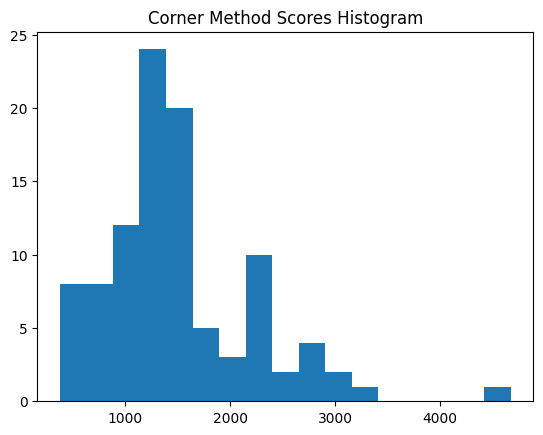

In [276]:
hist = np.histogram(corner_scores[0])
_ = plt.hist(corner_scores[0], bins='auto')  # arguments are passed to np.histogram
plt.title("Corner Method Scores Histogram")
plt.show()

dict_keys([32.0, 64.0, 128.0, 256.0, 512.0])


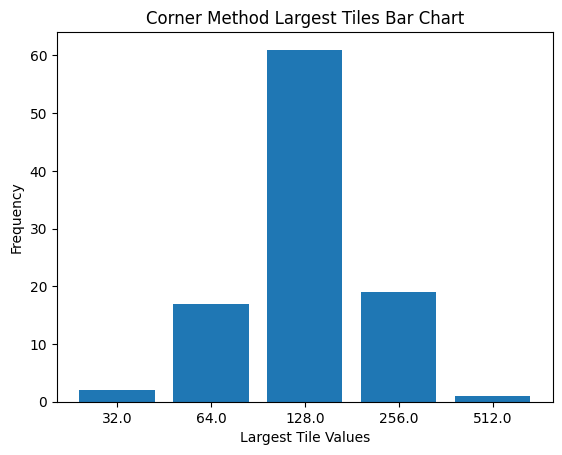

In [277]:
barplot(corner_scores[1])

In [224]:
down_scores = down(100)
print("alt corner scores: ", down_scores[0])
print("alt corner max tiles: ", down_scores[1])

alt corner scores:  [6656, 6768, 3856, 1680, 1660, 6600, 3796, 3220, 548, 2740, 6576, 3408, 3752, 6460, 2472, 1804, 2468, 1032, 2908, 3364, 3452, 1792, 3348, 3248, 5928, 2452, 2128, 3368, 2704, 3484, 6604, 924, 3400, 4104, 3352, 1048, 2656, 1504, 6484, 5768, 3380, 2568, 7356, 2496, 4248, 4768, 2768, 1732, 3356, 2060, 3352, 5604, 4108, 3148, 2620, 5768, 4880, 2052, 2780, 1860, 4448, 1592, 3224, 5520, 3276, 3996, 2896, 6824, 3600, 3648, 4232, 7056, 7192, 3016, 3064, 4964, 3356, 1912, 6540, 3348, 4336, 3764, 6804, 3344, 8016, 2716, 3492, 5760, 3628, 5796, 2688, 3448, 3472, 1912, 5024, 7984, 1392, 2332, 3296, 7488]
alt corner max tiles:  [512.0, 512.0, 256.0, 128.0, 128.0, 512.0, 256.0, 256.0, 64.0, 256.0, 512.0, 256.0, 256.0, 512.0, 256.0, 128.0, 256.0, 64.0, 256.0, 256.0, 256.0, 128.0, 256.0, 256.0, 512.0, 256.0, 256.0, 256.0, 256.0, 256.0, 512.0, 64.0, 256.0, 256.0, 256.0, 64.0, 256.0, 128.0, 512.0, 512.0, 256.0, 256.0, 512.0, 128.0, 256.0, 256.0, 256.0, 128.0, 256.0, 128.0, 256.0, 512.

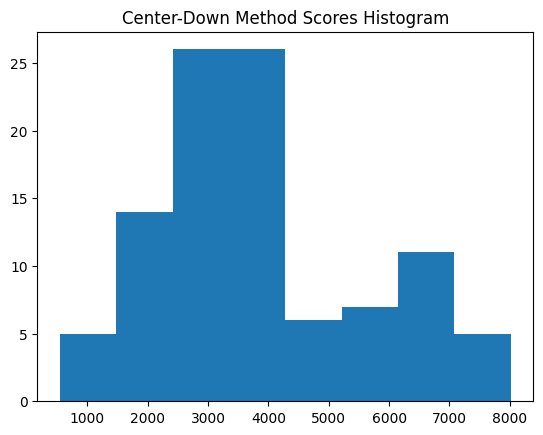

In [225]:
hist = np.histogram(down_scores[0])
_ = plt.hist(down_scores[0], bins='auto')  # arguments are passed to np.histogram
plt.title("Center-Down Method Scores Histogram")
plt.show()

dict_keys([64.0, 128.0, 256.0, 512.0])


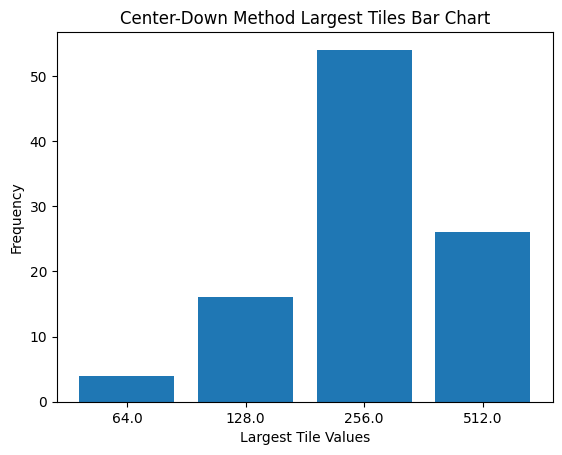

In [255]:
barplot(down_scores[1])

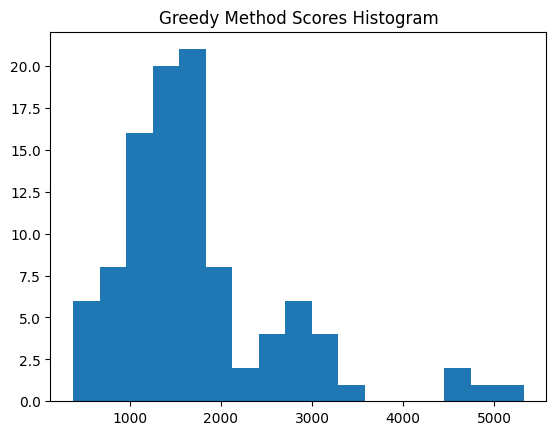

In [322]:
greedy_scores = greedy_method(100)
hist = np.histogram(greedy_scores[0])
_ = plt.hist(greedy_scores[0], bins='auto')  # arguments are passed to np.histogram
plt.title("Greedy Method Scores Histogram")
plt.show()

dict_keys([32.0, 64.0, 128.0, 256.0, 512.0])


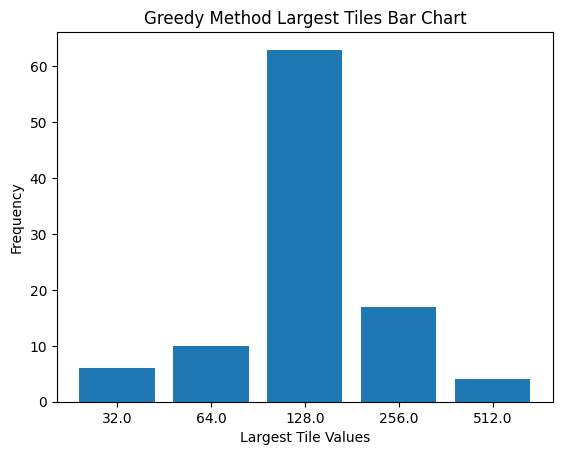

In [325]:
barplot(greedy_scores[1])

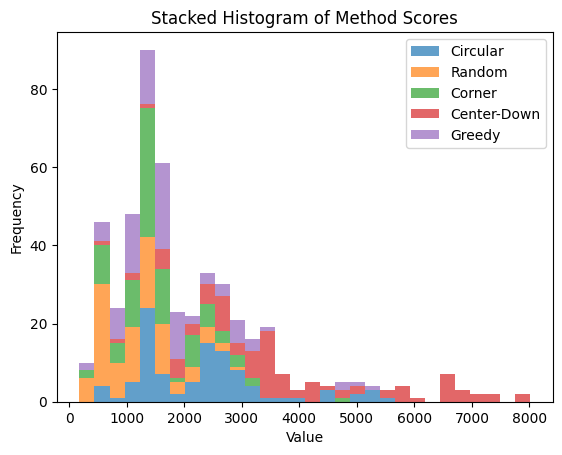

In [336]:
x = np.array([circular_scores[0], random_strat_scores[0], corner_scores[0], down_scores[0], greedy_scores[0]]).T
# print(x.shape)
# colors = ['yellow', 'lightblue', 'lightgreen', 'purple', 'pink']
# plt.legend(prop={'size': 10})
# plt.hist(x, bins='auto', density=True, histtype='bar', stacked=True, color=colors, label=colors)
# plt.title('stacked bar')

# plt.show()

plt.hist(x, bins=30, stacked=True, alpha=0.7, label=['Circular', 'Random', 'Corner', 'Center-Down', 'Greedy'])

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Method Scores')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [337]:
driver.close()  # comment out if you want to keep it open
driver.quit() # also does the same thing
